# Figure 1

In [1]:
import numpy as np
from scipy.signal import detrend
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

datapath = '../Processed_data/Nino3_4_DJF/'
experiments = ['piControl', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
models = ['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'E3SM-1-0', 
          'EC-Earth3', 'EC-Earth3-Veg', 'MIROC-ES2L', 'MIROC6', 'HadGEM3-GC31-LL',
           'HadGEM3-GC31-MM', 'UKESM1-0-LL', 'MRI-ESM2-0', 'GISS-E2-1-G', 'CESM2',
           'CESM2-WACCM', 'SAM0-UNICON', 'MCM-UA-1-0'] # , 'GFDL-ESM4'

In [2]:
def choose_member(datatable, exp, model):
    if 'r1i1p1f1' in datatable[exp]: # first priority
        chosen_member = 'r1i1p1f1'
    elif 'r1i1p1f2' in datatable[exp]: # second priority
        chosen_member = 'r1i1p1f2'       
    elif 'r1i1p1f3' in datatable[exp]: # etc.
        chosen_member = 'r1i1p1f3'
    elif 'r2i1p1f2' in datatable[exp]:
        chosen_member = 'r2i1p1f2'
    elif 'r22i1p1f1' in datatable[exp]:
        chosen_member = 'r22i1p1f1'    
    else: 
        print('failed for', exp, model, ' - add more members to test')
    return chosen_member
    
# find ensemble members that exists for all experiments:
def common_member(datatable):
    model_exp = list(set([exp[0] for exp in data_table.columns]))
    exp_members = {}
    for exp in model_exp:
        exp_members[exp] = set([member for member in data_table[exp].columns])
    common_members = set.intersection(*exp_members.values())
    return common_members



## List common ensemble members across experiments:

In [3]:
for (k,model) in enumerate(models):
    file = model + '_DJF_nino3_4index.txt'
    data_table = pd.read_csv(datapath + file,index_col=0, header=[0,1], keep_default_na = False)
    print(model, common_member(data_table))

BCC-CSM2-MR {'r1i1p1f1'}
CanESM5 {'r1i1p2f1', 'r1i1p1f1'}
CNRM-CM6-1 {'r1i1p1f2'}
CNRM-ESM2-1 set()
E3SM-1-0 {'r1i1p1f1'}
EC-Earth3 set()
EC-Earth3-Veg {'r1i1p1f1'}
MIROC-ES2L {'r1i1p1f2'}
MIROC6 {'r1i1p1f1'}
HadGEM3-GC31-LL set()
HadGEM3-GC31-MM {'r1i1p1f1'}
UKESM1-0-LL {'r1i1p1f2'}
MRI-ESM2-0 {'r1i1p1f1'}
GISS-E2-1-G {'r2i1p1f1', 'r1i1p1f2', 'r1i1p1f1', 'r102i1p1f1', 'r101i1p1f1'}
CESM2 {'r1i1p1f1'}
CESM2-WACCM {'r1i1p1f1'}
SAM0-UNICON {'r1i1p1f1'}
MCM-UA-1-0 set()


In [4]:
# define x-coordiates and colors for each experiment
x = {}
colors = ['black', 'blue', 'purple', 'red', 'green', 'gray']
color_dict = {}
delta_x = 0.1
for ind,exp in enumerate(experiments):
    x[exp] = np.arange(len(models)) + 1 + delta_x*ind
    color_dict[exp] = colors[ind]

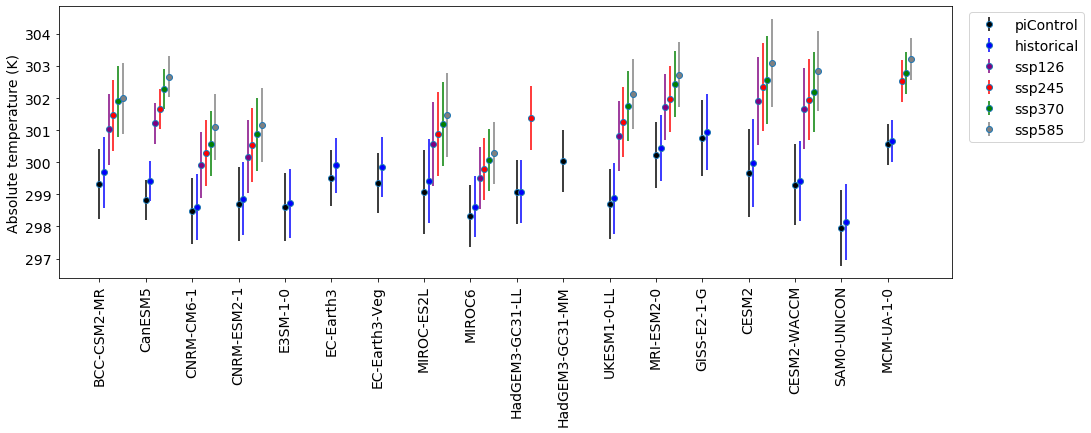

In [5]:
# create figure:
fig, ax = plt.subplots(figsize = [16,5])

for (k,model) in enumerate(models):
    #print(model)
    file = model + '_DJF_nino3_4index.txt'
    data_table = pd.read_csv(datapath + file,index_col=0, header=[0,1], keep_default_na = False)
    
    for exp in experiments:
        if exp in data_table:
            plot_member = choose_member(data_table, exp, model)
            data_list = data_table[exp][plot_member].values
            # remove empty strings and convert remaining strings to float:
            data = np.array([np.float(i) for i in data_list if i])
            
            if exp in experiments[-4:]: # if future scenario
                data = data[:86] # stop in year 2100
                
            if exp == 'piControl':
                control_data = data
            if k == 0:
                # define also labels for legend
                ax.errorbar(x[exp][k], data.mean(), yerr=control_data.std(), fmt='o', ecolor=color_dict[exp], mfc=color_dict[exp], label = exp)
            else:
                ax.errorbar(x[exp][k], data.mean(), yerr=control_data.std(), fmt='o', ecolor=color_dict[exp], mfc=color_dict[exp])
    
ax.tick_params(axis='both',labelsize=14)    
ax.set_ylabel('Absolute temperature (K)', fontsize = 14)
plt.xticks(x['piControl'], models, rotation=90);
ax.legend(loc=(1.02,0.5), fontsize = 14);

BCC-CSM2-MR r1i1p1f1 piControl
BCC-CSM2-MR r1i1p1f1 historical
BCC-CSM2-MR r1i1p1f1 ssp126
BCC-CSM2-MR r1i1p1f1 ssp245
BCC-CSM2-MR r1i1p1f1 ssp370
BCC-CSM2-MR r1i1p1f1 ssp585
CanESM5 r1i1p1f1 piControl
CanESM5 r1i1p1f1 historical
CanESM5 r1i1p1f1 ssp126
CanESM5 r1i1p1f1 ssp245
CanESM5 r1i1p1f1 ssp370
CanESM5 r1i1p1f1 ssp585
CNRM-CM6-1 r1i1p1f2 piControl
CNRM-CM6-1 r1i1p1f2 historical
CNRM-CM6-1 r1i1p1f2 ssp126
CNRM-CM6-1 r1i1p1f2 ssp245
CNRM-CM6-1 r1i1p1f2 ssp370
CNRM-CM6-1 r1i1p1f2 ssp585
CNRM-ESM2-1 r1i1p1f2 piControl
CNRM-ESM2-1 r1i1p1f2 historical
CNRM-ESM2-1 r1i1p1f2 ssp126
CNRM-ESM2-1 r1i1p1f2 ssp245
CNRM-ESM2-1 r2i1p1f2 ssp370
CNRM-ESM2-1 r2i1p1f2 ssp585
E3SM-1-0 r1i1p1f1 piControl
E3SM-1-0 r1i1p1f1 historical
EC-Earth3 r1i1p1f1 piControl
EC-Earth3 r22i1p1f1 historical
EC-Earth3-Veg r1i1p1f1 piControl
EC-Earth3-Veg r1i1p1f1 historical
MIROC-ES2L r1i1p1f2 piControl
MIROC-ES2L r1i1p1f2 historical
MIROC-ES2L r1i1p1f2 ssp126
MIROC-ES2L r1i1p1f2 ssp245
MIROC-ES2L r1i1p1f2 ssp370
MIRO

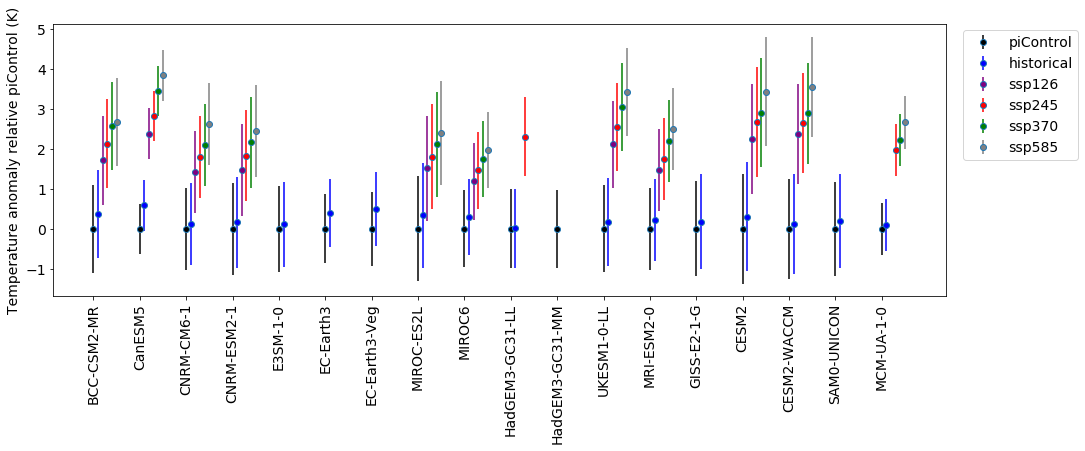

In [6]:
# create figure:
fig, ax = plt.subplots(figsize = [16,5])

for (k,model) in enumerate(models):
    #print(model)
    file = model + '_DJF_nino3_4index.txt'
    data_table = pd.read_csv(datapath + file,index_col=0, header=[0,1], keep_default_na = False)
    
    for exp in experiments:
        if exp in data_table:
            plot_member = choose_member(data_table, exp, model)
            print(model,plot_member, exp)
            data_list = data_table[exp][plot_member].values
            # remove empty strings and convert remaining strings to float:
            data = np.array([np.float(i) for i in data_list if i])
            
            if exp in experiments[-4:]: # if future scenario
                data = data[:86] # stop in year 2100
            
            if exp == 'piControl':
                control_data = data
            if k == 0:
                # define labels for legend
                ax.errorbar(x[exp][k], data.mean() - control_data.mean(), yerr=control_data.std(), fmt='o', ecolor=color_dict[exp], mfc=color_dict[exp], label = exp)
            else:
                ax.errorbar(x[exp][k], data.mean() - control_data.mean(), yerr=control_data.std(), fmt='o', ecolor=color_dict[exp], mfc=color_dict[exp])
    
ax.tick_params(axis='both',labelsize=14)    
ax.set_ylabel('Temperature anomaly relative piControl (K)', fontsize = 14)
plt.xticks(x['piControl'], models, rotation=90);
ax.legend(loc=(1.02,0.5), fontsize = 14);